In [1]:
import os
import sys
import requests
import datetime
from datetime import date

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import matplotlib.cm as cm
import matplotlib.colors as colors
import plotly
import plotly.graph_objs as go
from plotly.graph_objs import *
import plotly.offline as offline
import plotly.figure_factory as ff
import numpy as np
import seaborn as sns
import networkx as nx
#import osmnx as ox   # Error


Bad key "text.kerning_factor" on line 4 in
C:\Users\dun4g\anaconda3\envs\GIS\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# US COVID-19 Case Data Visualisation
## Procedure 1: US States and Counties GeoDataFrame (EPSG: 2163)
### US State

In [4]:
# Read US States Boundary Shapefile
us_states_gdf = gpd.read_file('C:/Users/dun4g/OneDrive/Documents/GitHub/COVID-19_Response_Comparison/Data/input/us_state/cb_2018_us_state_5m.shp')

# Converting the CRS to US National Atlas Equal Area Projection (EPSG: 2163)
us_states_gdf.to_crs(epsg=2163, inplace=True)

In [5]:
# Adding a column 'coords' for later use (labeling each State)
# https://stackoverflow.com/questions/38899190/geopandas-label-polygons
us_states_gdf['coords'] = us_states_gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
us_states_gdf['coords'] = [coords[0] for coords in us_states_gdf['coords']]

### US County

In [6]:
# Read US Counties Boundary Shapefile
us_counties_gdf = gpd.read_file('C:/Users/dun4g/OneDrive/Documents/GitHub/COVID-19_Response_Comparison/Data/input/us_counties/cb_2018_us_county_5m.shp')

# Adding a 'FULLFP' column that concatenates 'STATEFP' and 'COUNTYFP'
us_counties_gdf['FULLFP'] = us_counties_gdf['STATEFP'] + us_counties_gdf['COUNTYFP']

# Converting the CRS to US National Atlas Equal Area Projection (EPSG: 2163)
us_counties_gdf.to_crs(epsg=2163, inplace=True)

In [7]:
# Read US State Name, FIPS, and Postcode csv file 
fips_csv_dir = 'C:/Users/dun4g/OneDrive/Documents/GitHub/COVID-19_Response_Comparison/Data/input/us_state_fips/us-state-ansi-fips.csv'
fips_df = pd.read_csv(fips_csv_dir, dtype={' fips':object})

In [8]:
# Rename columns
fips_df.rename(columns=
    {' fips': 'fips',
    ' stusps': 'postcode',},
    inplace=True)

In [9]:
# Attribute Joins - Merging `us_counties_gdf` and `fips_df` on `'STATEFP'` and `'fips'`
merged_df = pd.merge(
    left=us_counties_gdf, 
    right=fips_df, 
    how='left', 
    left_on='STATEFP', 
    right_on='fips'
)

In [10]:
# Remove (drop) 'fips' column
merged_df = merged_df.drop(['fips'], axis=1)

In [11]:
# Make us_gdf a GeoDataFrame of merged_df
us_counties_gdf = gpd.GeoDataFrame(merged_df,
                                   crs={'init': 'epsg:2163'},
                                   geometry=merged_df['geometry'])

## Procedure 2: US COVID-19 Cases/Deaths/Testing DataFrame
### [New York Times US Counties Data](https://github.com/nytimes/covid-19-data)
### [Johns Hopkins Uni & Med US County](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series)
### [New York City Data](https://github.com/thecityny/covid-19-nyc-data)

In [13]:
# Read NYTimes COVID-19 US Counties Data
nytimes_counties_df = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv', 
                                  dtype={'fips':object}
                                 )

In [14]:
# Changing the 'date' dtype from object to datetime
nytimes_counties_df['date']=pd.to_datetime(nytimes_counties_df['date'])

# There are missing 'fips' values that will cause trouble later on
#nytimes_counties_df['fips'].fillna(0)

In [12]:
nytimes_counties_df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0
1,2020-01-22,Snohomish,Washington,53061,1,0
2,2020-01-23,Snohomish,Washington,53061,1,0
3,2020-01-24,Cook,Illinois,17031,1,0
4,2020-01-24,Snohomish,Washington,53061,1,0


# PROBLEM: There are unknown counties with NaN fips
### Possible Solution: Use the JHU's data instead of NYTimes (Ask how to use the data where each date is a column head)

In [18]:
null_fips_df = nytimes_counties_df[nytimes_counties_df['fips'].isnull()]
null_fips_df['county'].unique()

array(['New York City', 'Unknown', 'Kansas City'], dtype=object)

In [14]:
null_fips_df[null_fips_df['state']=='New York']

,date,county,state,fips,cases,deaths
416,2020-03-01,New York City,New York,NaN,1,0
448,2020-03-02,New York City,New York,NaN,1,0
482,2020-03-03,New York City,New York,NaN,2,0
518,2020-03-04,New York City,New York,NaN,2,0
565,2020-03-05,New York City,New York,NaN,4,0
...,...,...,...,...,...,...
105654,2020-05-01,New York City,New York,NaN,169701,12700
108522,2020-05-02,New York City,New York,NaN,172364,12895
111396,2020-05-03,New York City,New York,NaN,174341,13064
114279,2020-05-04,New York City,New York,NaN,175661,13207


In [15]:
# Creating a DataFrame for plotting charts (Set 'date' as the index)
nytimes_counties_plot_df = nytimes_counties_df.copy()
nytimes_counties_plot_df.set_index('date', inplace=True)

### [COVID Tracking Project Latest US & States Current Data](https://covidtracking.com/api)

In [19]:
# Read COVID Tracking Project US COVID-19 Current Data
covtrack_us_now_df = pd.read_json('https://covidtracking.com/api/v1/us/current.json')[['positive', 'death', 'total']]

In [20]:
# Read COVID Tracking Project US States COVID-19 Current Data
covtrack_states_now_df = pd.read_json('https://covidtracking.com/api/v1/states/current.json', dtype={'fips':object})[
    ['state', 'fips', 'positive', 'death', 'total']
]

### [COVID Tracking Project US Accumulative Data](https://covidtracking.com/api)

In [21]:
# Read COVID Tracking Project US COVID-19 Accumulative Data
covtrack_us_hist_df = pd.read_json('https://covidtracking.com/api/v1/us/daily.json', dtype={'fips':object})[
    ['date','positive', 'death', 'total']
]

In [22]:
# Creating a new column, 'datetime' that converts 'date' from dtype: int to the Dtype: str of datetime
covtrack_us_hist_df['datetime']=pd.to_datetime(covtrack_us_hist_df['date'].astype(str), format='%Y-%m-%d')

# Converting the Dtype to datetime
covtrack_us_hist_df['datetime']=pd.to_datetime(covtrack_us_hist_df['datetime'])

In [23]:
# Creating a DataFrame for plotting charts (Set 'datetime' as the index)
covtrack_us_hist_plot_df = covtrack_us_hist_df[['datetime', 'positive', 'death', 'total']].copy()
covtrack_us_hist_plot_df.set_index('datetime', inplace=True)

### [COVID Tracking Project States Accumulative Data](https://covidtracking.com/api)

In [24]:
# Read COVID Tracking Project US States COVID-19 Accumulative Data
covtrack_states_hist_df = pd.read_json('https://covidtracking.com/api/v1/states/daily.json', dtype={'fips':object})[
    ['date', 'state', 'fips', 'positive', 'death', 'total']
]

In [25]:
# Creating a new column, 'datetime' that converts 'date' from dtype: int to the Dtype: str of datetime
covtrack_states_hist_df['datetime']=pd.to_datetime(covtrack_states_hist_df['date'].astype(str), format='%Y-%m-%d')

# Converting the Dtype to datetime
covtrack_states_hist_df['datetime']=pd.to_datetime(covtrack_states_hist_df['datetime'])

In [26]:
# # Creating a DataFrame for plotting charts (Set 'datetime' as the index)
covtrack_states_hist_plot_df = covtrack_states_hist_df[['datetime', 'state', 'fips', 'positive', 'death', 'total']].copy()
covtrack_states_hist_plot_df.set_index('datetime', inplace=True)

## Procedure 3: Merge US COVID-19 DataFrame with GeoDataFrame `us_cov19_counties_gdf` and `us_cov19_states_gdf`
### `nytimes_counties_df`

In [24]:
# Merge NYTimes US Counties COVID-19 Data with us_counties_gdf
us_cov19_counties_df = pd.merge(
    nytimes_counties_df,
    us_counties_gdf[['FULLFP', 'STATEFP', 'COUNTYFP', 'geometry', 'postcode']],
    left_on='fips',
    right_on='FULLFP',
    how='left',
)

In [25]:
us_cov19_counties_gdf = gpd.GeoDataFrame(us_cov19_counties_df, 
                                         crs={'init': 'epsg:2163'},
                                         geometry='geometry')

In [26]:
us_cov19_counties_gdf = us_cov19_counties_gdf.drop(['FULLFP'], axis=1)

# <font color = 'orangered'> This works only sometimes... </font>

In [67]:
# us_cov19_counties_plot_gdf = us_cov19_counties_gdf[['date', 'county', 'state', 'postcode', 'fips', 
#                                                     'STATEFP', 'COUNTYFP', 'cases', 'deaths', 'geometry']].copy
# us_cov19_counties_plot_gdf.set_index('date', inplace=True)

### `covtrack_states_now_df`

In [27]:
# Merge COVID Tracking Project US States COVID-19 Accumulative Data with us_states_gdf
us_cov19_states_now_df = pd.merge(
    covtrack_states_now_df,
    us_states_gdf[['STATEFP', 'NAME', 'coords', 'geometry']],
    left_on='fips',
    right_on='STATEFP',
    how='left',
)

In [28]:
us_cov19_states_now_gdf = gpd.GeoDataFrame(us_cov19_states_now_df, 
                                           crs={'init': 'epsg:2163'},
                                           geometry='geometry')

In [29]:
us_cov19_states_now_gdf = us_cov19_states_now_gdf.drop(['STATEFP'], axis=1)

In [46]:
us_cov19_states_now_gdf.head()

,state,fips,positive,death,total,NAME,coords,geometry
0,AK,02,372,10,23655,Alaska,"(-2180339.847699951, 2622589.4473532755)","MULTIPOLYGON (((-4288629.978 3426273.416, -428..."
1,AL,01,8581,340,109516,Alabama,"(1249493.1603794529, -1279834.742587857)","MULTIPOLYGON (((1150023.442 -1526367.945, 1150..."
2,AR,05,3568,85,59003,Arkansas,"(685109.6121825308, -1101604.851975698)","POLYGON ((482000.986 -928930.836, 487242.080 -..."
3,AZ,04,9707,426,91737,Arizona,"(-1085734.3498492904, -1127761.0539318295)","POLYGON ((-1386135.563 -1256471.688, -1386636...."
4,CA,06,58815,2412,809036,California,"(-1751658.9889987549, -642191.5542591754)","MULTIPOLYGON (((-1717278.368 -1090204.876, -17..."


### `covtrack_states_hist_df`

In [30]:
# Merge COVID Tracking Project US States COVID-19 Accumulative Data with us_states_gdf
us_cov19_states_df = pd.merge(
    covtrack_states_hist_df,
    us_states_gdf[['STATEFP', 'NAME', 'coords', 'geometry']],
    left_on='fips',
    right_on='STATEFP',
    how='left',
)

In [31]:
us_cov19_states_gdf = gpd.GeoDataFrame(us_cov19_states_df, 
                                       crs={'init': 'epsg:2163'},
                                       geometry='geometry')

In [32]:
us_cov19_states_gdf = us_cov19_states_gdf.drop(['STATEFP'], axis=1)

In [33]:
# Creating a DataFrame for plotting charts (Set 'datetime' as the index)
us_cov19_states_plot_gdf = us_cov19_states_gdf[['datetime', 'date', 'NAME', 'state', 'fips', 'positive', 'death', 'total', 'coords', 'geometry']].copy()
us_cov19_states_plot_gdf.set_index('datetime', inplace=True)

## Procedure 4: US COVID-19 Data Visualisation
### US History Chart `covtrack_us_hist_df`

## <font color = 'orangered'> QUESTION 2: How do I set the x-axis label (date) to show in `%b %d` format by monthly?? </font>

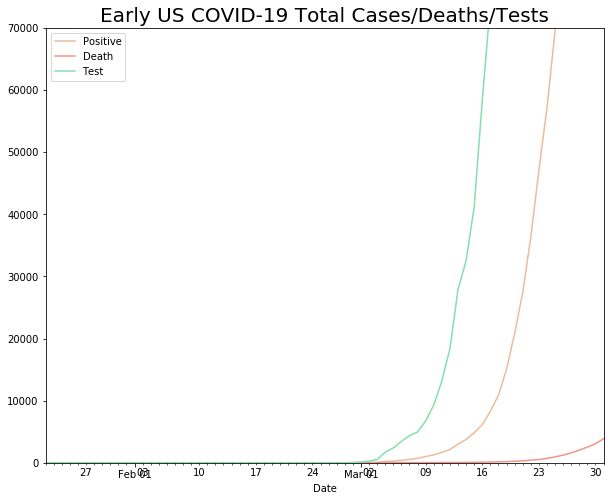

In [70]:
fig, ax = plt.subplots(figsize=(10,8))

covtrack_us_hist_plot_df.plot(
    ax=ax,
    #x='datetime',
    y=['positive', 'death', 'total'],
    color=['#EDBB99', '#F1948A', '#82E0AA'],
    xlim=('2020-01-22', '2020-03-31'),
    ylim=(0, 70000),
);

# x-axis label
plt.xlabel('Date')

# Rename legend
ax.legend(['Positive', 'Death', 'Test'])

# set ticks every month
ax.xaxis.set_major_locator(mdates.MonthLocator())

# set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.title('Early US COVID-19 Total Cases/Deaths/Tests', fontdict={'size':20});

### US States Confirmed Cases `us_cov19_states_now_gdf`
## <font color = 'orangered'> QUESTION 3: How do I change the pre-set legend values?  BoxPlot scheme is good but I just want the numbers to be prettier like 20,000 instead of 20,482.25. </font>

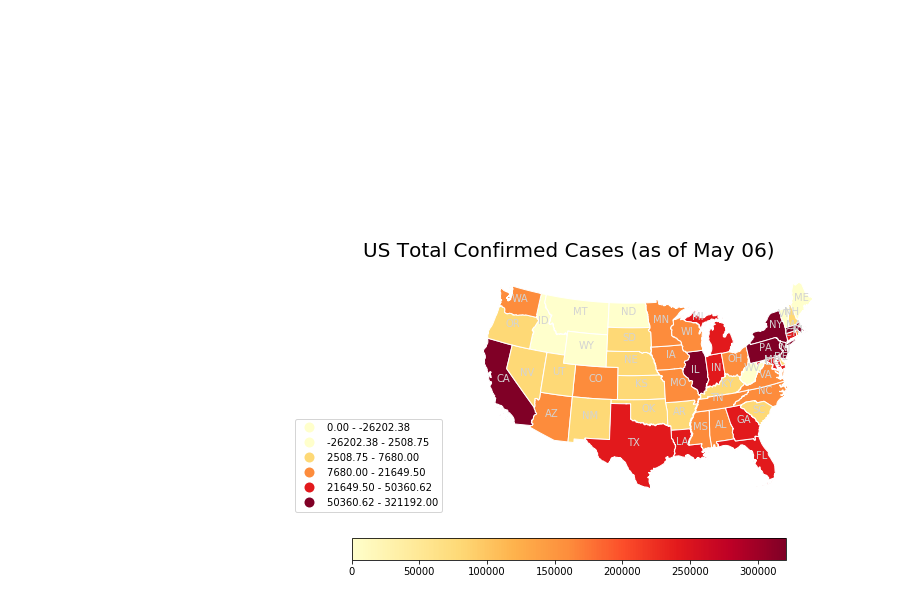

In [36]:
# from datetime import date

fig, ax = plt.subplots(figsize=(10,8))

# Normalize the Legend Color and create the legend bar
# https://towardsdatascience.com/mapping-with-matplotlib-pandas-geopandas-and-basemap-in-python-d11b57ab5dac
vmin, vmax = us_cov19_states_now_gdf.positive.min(), us_cov19_states_now_gdf.positive.max()
legend_bar = plt.cm.ScalarMappable(
     norm=plt.Normalize(vmin=vmin, vmax=vmax), 
     cmap='YlOrRd')

# Plot
us_cov19_states_now_gdf.plot(
    ax=ax,
    column='positive',
    cmap='YlOrRd',
    #markersize=2,
    edgecolor='white',
    legend=True,
    scheme='BoxPlot', # or Quantile,
    legend_kwds={'loc': 'lower left'},
)

# Title  
today = datetime.datetime.now()
ax.set_title('US Total Confirmed Cases (as of ' + today.strftime('%b %d') + ')', fontdict={'size':20});

# Add the Color Legend Bar
# https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
fig.colorbar(legend_bar, ax=ax, orientation='horizontal', fraction=0.05, pad=0.05, shrink=0.8)

# Customizing legend values
# leg = ax.get_legend()
# leg.get_texts()[0].('New label 1')
# leg.get_texts()[1].set_text('New label 2')

# Displaying each State Postcode
for idx, row in us_cov19_states_now_gdf.iterrows():
    plt.annotate(s=row['state'], xy=row['coords'],
                 horizontalalignment='center',
                 #font.family='serif',
                 color='lightgrey',
                 #alpha=0.9,
                 #bbox={'facecolor':'white', 'alpha':0.5, 'pad':1, 'edgecolor':'lightyellow'}
                )

# Turn off the box and the axes label
ax.axis(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Crop the map to an appropriate size (via coordinate)
ax.set_xlim(-4700000, 3000000)
ax.set_ylim(-2500000, 1000000);
# ax.set_ylim(-2500000, 4200000);  # shows alaska

### More interactive choropleth map of the US State Total Confirmed Cases 

In [47]:
us_cov19_states_now_df.head()

,state,fips,positive,death,total,STATEFP,NAME,coords,geometry
0,AK,02,372,10,23655,02,Alaska,"(-2180339.847699951, 2622589.4473532755)","MULTIPOLYGON (((-4288629.978 3426273.416, -428..."
1,AL,01,8581,340,109516,01,Alabama,"(1249493.1603794529, -1279834.742587857)","MULTIPOLYGON (((1150023.442 -1526367.945, 1150..."
2,AR,05,3568,85,59003,05,Arkansas,"(685109.6121825308, -1101604.851975698)","POLYGON ((482000.986 -928930.836, 487242.080 -..."
3,AZ,04,9707,426,91737,04,Arizona,"(-1085734.3498492904, -1127761.0539318295)","POLYGON ((-1386135.563 -1256471.688, -1386636...."
4,CA,06,58815,2412,809036,06,California,"(-1751658.9889987549, -642191.5542591754)","MULTIPOLYGON (((-1717278.368 -1090204.876, -17..."


In [69]:
# color scheme for the map plot (white to red)
state_color_scale = ['#FFEBEE', '#FFCDD2', '#EF9A9A', '#E57373', '#EF5350', 
                      '#F44336', '#E53935', '#D32F2F', '#C62828', '#B71C1C']

# creating a new column that will include the mouse-hovering text for each state
for col in us_cov19_states_now_df.columns:
    us_cov19_states_now_df[col] = us_cov19_states_now_df[col].astype(str)

# us_cov19_states_now_df['positive'] = us_cov19_states_now_df.apply(lambda x: "{:,}".format(x['positive']), axis=1)
# us_cov19_states_now_df['total'] = us_cov19_states_now_df.apply(lambda x: "{:,}".format(x['total']), axis=1)

us_cov19_states_now_df['text'] = us_cov19_states_now_df['NAME'] + '<br>' + \
                        'Deaths: ' + us_cov19_states_now_df['death'] + '<br>' + \
                        'Tests: ' + us_cov19_states_now_df['total']

fig = go.Figure(data=go.Choropleth(
    locations=us_cov19_states_now_df['state'],  # the column with the state post code
    z = us_cov19_states_now_df['positive'].astype(float),  # the variable I want to color-code
    locationmode = 'USA-states',
    #binning_endpoints=[2500, 7500, 21000, 50000, 350000],
    zmax = 350000,
    zmid = 30000,
    zmin = 0,
    colorscale = state_color_scale, # 'YlOrRd',
    autocolorscale = False,
    text = us_cov19_states_now_df['text'], # hover text
    marker_line_color = 'white',     # for the lines separating states
    marker_line_width = 2,    
    colorbar_title = 'Confirmed Cases'
))

state_latest_update = datetime.datetime.now()

# updating the layout
fig.update_layout(
    title_text = 'US State COVID-19 Confirmed Cases (latest update: ' + state_latest_update.strftime('%b %d') + ')',
    geo = dict(
            scope = 'usa',
            projection=go.layout.geo.Projection(type='albers usa'),
            # showlakes = True,  # if you want to give color to the lakes
            # lakecolor = 'rgb(73, 216, 230)'
    )
)

fig.show()

### by US Counties `us_cov19_counties_df`

Plotly Choropleth Maps: https://plotly.com/python/choropleth-maps/

Interactive Map 1: https://towardsdatascience.com/a-complete-guide-to-an-interactive-geographical-map-using-python-f4c5197e23e0

Interactive Map 2: https://amaral.northwestern.edu/blog/step-step-how-plot-map-slider-represent-time-evolu

In [64]:
us_cov19_counties_df.head()

,date,county,state,fips,cases,deaths,FULLFP,STATEFP,COUNTYFP,geometry,postcode
0,2020-01-21,Snohomish,Washington,53061,1,0,53061,53,061,"MULTIPOLYGON (((-1634037.628 566970.701, -1633...",WA
1,2020-01-22,Snohomish,Washington,53061,1,0,53061,53,061,"MULTIPOLYGON (((-1634037.628 566970.701, -1633...",WA
2,2020-01-23,Snohomish,Washington,53061,1,0,53061,53,061,"MULTIPOLYGON (((-1634037.628 566970.701, -1633...",WA
3,2020-01-24,Cook,Illinois,17031,1,0,17031,17,031,"POLYGON ((965008.651 -256879.590, 966661.997 -...",IL
4,2020-01-24,Snohomish,Washington,53061,1,0,53061,53,061,"MULTIPOLYGON (((-1634037.628 566970.701, -1633...",WA


In [37]:
# import datetime
county_start_date = datetime.datetime(2020, 5, 4)

county_start_df = us_cov19_counties_df[(us_cov19_counties_df['date']==county_start_date)]

In [38]:
# color scheme for the map plot (white to red)
county_color_scale = ['#FFEBEE', '#FFCDD2', '#EF9A9A', '#E57373', '#EF5350', 
                      '#F44336', '#E53935', '#D32F2F', '#C62828', '#B71C1C']

# creating a new column that will include the mouse-hovering text for each county
# for col in county_start_df.columns:
#     county_start_df[col] = county_start_df[col].astype(str)

# county_start_df['text'] = county_start_df['county'] + ', ' + county_start_df['postcode'] + '<br>' + \
#                         'Cases: ' + county_start_df['cases'] + '<br>' + \
#                         'Deaths: ' + county_start_df['deaths']

# PROBLEM: Possibly because of the missing `fips` value from `nytimes` data?

#### Use [JHU counties data](https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv) instead.  https://chrisalbon.com/ can help with transposing the data

In [41]:
#import plotly.figure_factory as ff

#endpts = list(np.linspace(1, 350000, len(county_color_scale)-1))
fips = county_start_df['fips'].tolist()
values = county_start_df['cases'].tolist()

# creating a fig object for plotting
fig = ff.create_choropleth(
    fips=fips, values=values, scope=['usa'],
    binning_endpoints=[2500, 7500, 21000, 50000, 350000], # scheme: 'boxplot'
    colorscale=county_color_scale,
    county_outline={'color': 'rgb(255,255,255)', 'width': 0.5}, 
    round_legend_values=True,
    show_state_data=False,
    show_hover=True,
    asp=2.9,   #Sets the ratio between height and width
    title_text='US COVID-19 Confirmed Cases (latest update: ' + county_start_date.strftime('%b %d') + ')',
    legend_title='Confirmed Cases',
)

fig.layout.template = None
fig.show()
    
# fig = go.Figure(data=go.Choropleth(
#     locations=county_start_df['fips'],  # the column with the county fips
#     z = county_start_df['cases'].astype(float),  # the variable I want to color-code
#     locationmode = 'USA-states',
#     colorscale = county_color_scale,
#     autocolorscale = False,
#     text = county_start_df['text'], # hover text
#     marker_line_color = 'white',     # for the lines separating states
#     marker_line_width = 2,    
#     colorbar_title = 'COVID-19 Confirmed Cases'
# ))

ValueError: cannot convert float NaN to integer

### by US States `covtrack_state_hist_df` or `us_cov19_states_gdf` 
Interactive Map 2: https://amaral.northwestern.edu/blog/step-step-how-plot-map-slider-represent-time-evolu

In [97]:
us_cov19_states_df.shape

(3377, 11)

In [43]:
# import datetime
state_start_date = datetime.datetime(2020, 1, 22)

state_start_df = us_cov19_states_df[(us_cov19_states_df['datetime']==state_start_date)]

In [44]:
state_start_df

,date,state,fips,positive,death,total,datetime,STATEFP,NAME,coords,geometry
3488,20200122,WA,53,1.0,NaN,1,2020-01-22,53,Washington,"(-1527952.2481166585, 464302.92549199006)","MULTIPOLYGON (((-1634037.628 566970.701, -1633..."


In [45]:
# color scheme for the map plot (white to red)
state_color_scale = [[0.0, '#ffffff'], [0.2, '#ff9999'], [0.4, '#ff4d4d'],
                     [0.6, '#ff1a1a'], [0.8, '#cc0000'], [1.0, '#4d0000']]

# create an empty list for data object:
data_slider = []

In [37]:
# populate the data object, one dictionary per day that will be displayed with the slider, by iterating over the different years in the data set
for date in us_cov19_states_df.datetime.unique():
    
    # select the date
    each_day_state_df = us_cov19_states_df[(us_cov19_states_df['datetime']==date)]
    
    # creating a new column that will include the mouse-hovering text for each state
    for col in each_day_state_df.columns:
        each_day_state_df[col] = each_day_state_df[col].astype(str)

    # creating the text for mouse-hover for each state
    each_day_state_df['text'] = each_day_state_df['NAME'] + 'Cases: ' + each_day_state_df['positive'] + 'Deaths: ' + each_day_state_df['death'] + 'Tests: ' + each_day_state_df['total']
    
    # create the dictionary with the data for plotting the current date
    data_one_day = [ dict(
                        type='choropleth', # type of map-plot
                        colorscale = state_color_scale,
                        autocolorscale = False,
                        locations = each_day_state_df['state'], # the column with the state post code
                        z = each_day_state_df['positive'].astype(float), # the variable I want to color-code
                        locationmode = 'USA-states',
                        text = each_day_state_df['text'], # hover text
                        marker = dict(     # for the lines separating states
                                    line = dict (
                                              color = 'rgb(255,255,255)', 
                                              width = 2) ),               
                        colorbar = dict(
                                    title = "Confirmed Cases")
                        ) 
                   ]
    
    # add the dictionary to the list of dictionaries for the slider
    data_slider.append(data_one_day)

# <font color='red'> QUESTION : How do I make the slider step to be each date? </font>

In [118]:
# Create the 'steps' for the slider

steps = []

# start_date = datetime.date(2020, 1, 22)
# delta = datetime.timedelta(days=1)

for i in range(len(data_slider)):
    step = dict(method='restyle',
                args=['visible', [False] * len(data_slider)],
                label=f'{i + 1}') # label to be displayed for each step (date)
    step['args'][1][i] = True
    steps.append(step)
    
# Create the sliders object from the steps
sliders = [dict(active=0, pad={'t': 1}, steps=steps)]
    

In [272]:
# set up the layout including the slider option
layout = dict(
        title = state_start_date.strftime('%b %d'),
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            # showlakes = True,  # if you want to give color to the lakes
            # lakecolor = 'rgb(73, 216, 230)'  
            ),
        sliders=sliders,
        )


fig = dict(data=data_slider, layout=layout)


# plot
#plotly.offline.iplot(fig)

# if want to plot in a different window on your browser
# offline.plot(
#     fig, 
#     auto_open=True, 
#     image = 'png', 
#     image_filename="US State COVID-19 Confirmed Cases"+str(state_start_date.strftime('%b %d')),  
#     image_width=2000, image_height=1000, 
#     filename='/C:/Users/dun4g/OneDrive/Documents/GitHub/COVID-19_Response_Comparison/temp-plot.html'/span>"US State COVID-19 Confirmed Cases"str(state_start_date.strftime('%b %d'))+'.html', validate=True)

NameError: name 'state_start_date' is not defined

# South Korea COVID-19 Case Data Visualisation
## Procedure 1: South Korea Provinces and Special/Metropolitan Cities GeoDataFrame (EPSG: 4326)

In [73]:
# Read in Natural Earth Large Scale Cultural Data (Admin 1 - States and Provinces) Boundary Shapefile
ne_admin_1_states_gdf = gpd.read_file('Data/input/ne_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp')

In [74]:
# Create a GeoDataFrame for South Korea Provinces & Special/Metropolitan Cities ONLY
south_korea_gdf=ne_admin_1_states_gdf[ne_admin_1_states_gdf['admin']=='South Korea']

In [75]:
# Keep the only columns that needed
south_korea_gdf = south_korea_gdf[['geonunit', 'gu_a3', 'gn_name', 'name_de', 'fips', 'latitude', 'longitude', 'geometry']]

In [76]:
# Adding a column 'coords' for later use (labeling each Province)
# https://stackoverflow.com/questions/38899190/geopandas-label-polygons
south_korea_gdf['coords'] = south_korea_gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
south_korea_gdf['coords'] = [coords[0] for coords in south_korea_gdf['coords']]

## Procedure 2: South Korea COVID-19 Cases/Deaths/Testing DataFrame
### [South Korea Latest Update](https://github.com/katkim0307/COVID-19_Response_Comparison/blob/master/Data/input/covid_19_south_korea_full_no_airport_xls.xlsx?raw=true)

### [South Korea Latest Update by Province](https://github.com/katkim0307/COVID-19_Response_Comparison/blob/master/Data/input/covid_19_south_korea_full_no_airport_xls.xlsx?raw=true)

In [77]:
# Read 
kor_cov19_province_now_df = pd.read_excel('Data/input/covid_19_south_korea_full_no_airport_xls.xlsx',
                            sheet_name='covid_19_update')

kor_cov19_province_now_df.head()

,Date,Province,Confirm_New,Confirm_Tot,Death_New,Death_Tot,Test_New,Test_Tot,Test_Curr
0,2020-05-05,Seoul,0,637,0,2,1182.0,467.0,118241.0
1,2020-05-05,Busan,0,138,0,3,NaN,NaN,NaN
2,2020-05-05,Daegu,0,6856,1,177,NaN,NaN,NaN
3,2020-05-05,Incheon,2,563,0,0,NaN,NaN,NaN
4,2020-05-05,Gwangju,0,30,0,0,NaN,NaN,NaN


### [South Korea History Data](https://github.com/katkim0307/COVID-19_Response_Comparison/blob/master/Data/input/covid_19_south_korea_full_no_airport_xls.xlsx?raw=true)

In [78]:
# Read 
kor_cov19_df = pd.read_excel('Data/input/covid_19_south_korea_full_no_airport_xls.xlsx',
                            sheet_name='covid_19_daily_country')

kor_cov19_df.fillna(0, inplace=True)

In [79]:
kor_cov19_df.head()

,Date,Country,Confirm_New,Confirm_Tot,Death_New,Death_Tot,Test_New,Test_Tot,Test_Curr
0,2020-01-20,South Korea,1,1,0,0,4,4,0
1,2020-01-24,South Korea,1,2,0,0,23,27,0
2,2020-01-26,South Korea,1,3,0,0,24,51,1
3,2020-01-27,South Korea,1,4,0,0,10,61,1
4,2020-01-28,South Korea,0,4,0,0,55,116,15


In [45]:
kor_cov19_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         100 non-null    datetime64[ns]
 1   Country      100 non-null    object        
 2   Confirm_New  100 non-null    int64         
 3   Confirm_Tot  100 non-null    int64         
 4   Death_New    100 non-null    int64         
 5   Death_Tot    100 non-null    int64         
 6   Test_New     100 non-null    int64         
 7   Test_Tot     100 non-null    int64         
 8   Test_Curr    100 non-null    int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 7.2+ KB


In [80]:
# Creating a DataFrame for plotting charts (Set 'Date' as the index)
kor_cov19_plot_df = kor_cov19_df[['Date', 'Confirm_New', 'Confirm_Tot', 
                                'Death_New', 'Death_Tot', 
                                'Test_New', 'Test_Tot', 'Test_Curr']].copy()
kor_cov19_plot_df.set_index('Date', inplace=True)

### [South Korea Provinces and Special/Metropolitan Cities Data](https://github.com/katkim0307/COVID-19_Response_Comparison/blob/master/Data/input/covid_19_south_korea_full_xls.xlsx)

In [81]:
# Read
kor_cov19_province_df = pd.read_excel('Data/input/covid_19_south_korea_full_no_airport_xls.xlsx',
                                      sheet_name='covid_19_daily_province')

In [82]:
# Converting the Dtype of 'Date' to datetime
kor_cov19_province_df['Date']=pd.to_datetime(kor_cov19_province_df['Date'])

# Converting the Dtype of 'Test_Tot' from object to float
kor_cov19_province_df['Test_Tot']=kor_cov19_province_df['Test_Tot'].astype('category').cat.codes.astype(float)

In [83]:
kor_cov19_province_df.update(kor_cov19_province_df[['Confirm_New', 'Confirm_Tot', 'Death_New', 'Death_Tot', "Test_New", 'Test_Tot', 'Test_Curr']].fillna(0))

In [84]:
# Creating a DataFrame for plotting charts (Set 'Date' as the index)
kor_cov19_province_plot_df = kor_cov19_province_df[['Date', 'Province', 'Confirm_New', 'Confirm_Tot', 
                                                 'Death_New', 'Death_Tot', 
                                                 'Test_New', 'Test_Tot', 'Test_Curr']].copy()
kor_cov19_province_plot_df.set_index('Date', inplace=True)

## Procedure 3: Merge South Korea COVID-19 DataFrame with Province GeoDataFrame 
### `kor_cov19_province_now_df`

In [85]:
kor_cov19_province_now_merged_df = pd.merge(
    kor_cov19_province_now_df,
    south_korea_gdf[['geonunit', 'name_de', 'fips', 'latitude', 'longitude', 'geometry', 'coords']],
    left_on='Province',
    right_on='name_de',
    how='left',
)

In [86]:
kor_cov19_province_now_merged_df = kor_cov19_province_now_merged_df.drop(['name_de'], axis=1)

In [87]:
kor_cov19_province_now_gdf = gpd.GeoDataFrame(kor_cov19_province_now_merged_df, 
                                              crs={'init': 'epsg:4326'},
                                              geometry='geometry')

### `kor_cov_19_province_df`

In [88]:
kor_cov19_province_merged_df = pd.merge(
    kor_cov19_province_df,
    south_korea_gdf[['geonunit', 'name_de', 'fips', 'latitude', 'longitude', 'geometry', 'coords']],
    left_on='Province',
    right_on='name_de',
    how='left',
)

In [89]:
kor_cov19_province_merged_df = kor_cov19_province_merged_df.drop(['name_de'], axis=1)

In [90]:
kor_cov19_province_gdf = gpd.GeoDataFrame(kor_cov19_province_merged_df, 
                                          crs={'init': 'epsg:4326'},
                                          geometry='geometry')

In [91]:
# Creating a DataFrame for plotting charts (Set 'Date' as the index)
kor_cov19_province_plot_gdf = kor_cov19_province_gdf.copy()
kor_cov19_province_plot_gdf.set_index('Date', inplace=True)

## Procedure 4: South Korea COVID-19 Data Visualisation
### South Korea History Chart `kor_cov19_plot_df`

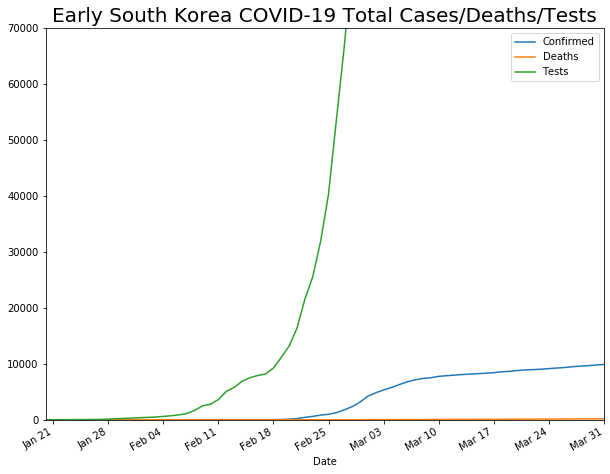

In [92]:
fig, ax = plt.subplots(figsize=(10, 8))

kor_cov19_plot_df.plot(
    ax=ax,
    #x='datetime',
    y=['Confirm_Tot', 'Death_Tot', 'Test_Tot'],
    xlim=('2020-01-20', '2020-03-31'),
    ylim=(0, 70000),
    figsize=(10, 8),
);

# x-axis label
plt.xlabel('Date')

# Rename legend
ax.legend(['Confirmed', 'Deaths', 'Tests'])

# set ticks every month
ax.xaxis.set_major_locator(mdates.WeekdayLocator())

# set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.title('Early South Korea COVID-19 Total Cases/Deaths/Tests', fontdict={'size':20});

### South Korea Confirmed Cases Map - `kor_cov19_province_now_gdf`

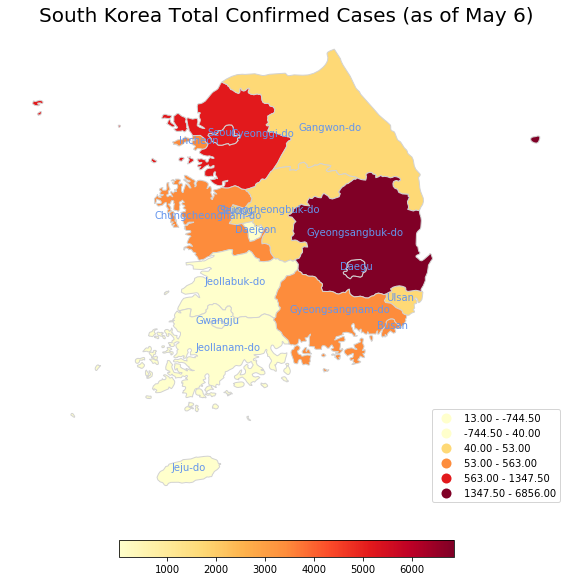

In [96]:
fig, ax = plt.subplots(figsize=(10,15))

# Normalize the Legend Color and create the legend bar
# https://towardsdatascience.com/mapping-with-matplotlib-pandas-geopandas-and-basemap-in-python-d11b57ab5dac
vmin, vmax = kor_cov19_province_now_gdf.Confirm_Tot.min(), kor_cov19_province_plot_gdf.Confirm_Tot.max()
legend_bar = plt.cm.ScalarMappable(
     norm=plt.Normalize(vmin=vmin, vmax=vmax), 
     cmap='YlOrRd')

# Plot
kor_cov19_province_now_gdf.plot(
    ax=ax,
    column='Confirm_Tot',
    cmap='YlOrRd',
    #markersize=2,
    edgecolor='lightgrey',
    legend=True,
    scheme='BoxPlot', # or Quantile,
    legend_kwds={'loc': 'lower right'},
)

# Title  
ax.set_title('South Korea Total Confirmed Cases (as of May 6)', fontdict={'size':20});

# Add the Color Legend Bar
# https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
fig.colorbar(legend_bar, ax=ax, orientation='horizontal', fraction=0.05, pad=0.04, shrink=0.6)

# Customizing legend values
# leg = ax.get_legend()
# leg.get_texts()[0].('New label 1')
# leg.get_texts()[1].set_text('New label 2')

# Displaying each State Postcode
for idx, row in kor_cov19_province_now_gdf.iterrows():
    plt.annotate(s=row['Province'], xy=row['coords'],
                 horizontalalignment='center',
                 #font.family='serif',
                 color='cornflowerblue',
                 #alpha=0.9,
                 #bbox={'facecolor':'white', 'alpha':0.5, 'pad':1, 'edgecolor':'lightyellow'}
                )

# Turn off the box and the axes label
ax.axis(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Crop the map to an appropriate size (via coordinate)
# ax.set_xlim(-4700000, 3000000)
# ax.set_ylim(-2500000, 4200000);

### South Korea Confirmed Cases History Map -  `kor_cov19_province_plot_gdf`

# US vs. South Korea COVID-19 Total Cases & Tests
### `covtrack_us_hist_plot_df` & `kor_cov19_plot_df` 
[Map reference](https://stackoverflow.com/questions/45574099/plot-different-columns-of-different-dataframe-in-the-same-plot-with-pandas)

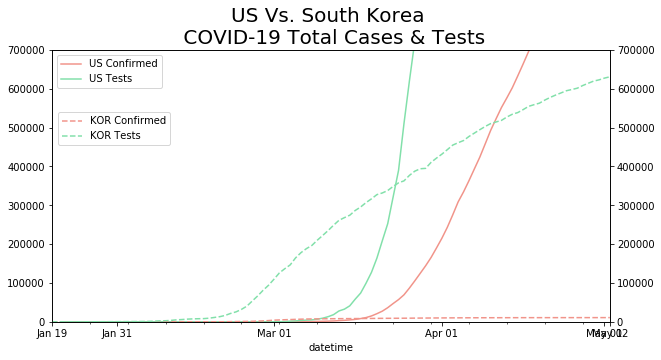

In [98]:
# x_axis_start = datetime.datetime(2020, 1, 1).strftime('%b %d')
# x_axis_end = datetime.datetime(2020, 5, 5).strftime('%b %d')
# x_axis_sample = datetime.datetime(2020, 1, 1).strftime('%b %d')


# x_axis = np.linspace(x_axis_start, x_axis_end, x_axis=sample)

fig, ax = plt.subplots(figsize=(10,5))
ax2 = ax.twinx()



covtrack_us_hist_plot_df.plot(
    ax=ax,
    y=['positive', 'total'],
    color=['#F1948A', '#82E0AA'],
    ylim=(0, 700000),
)

kor_cov19_plot_df.plot(
    ax=ax2,
    ls='--',
    y=['Confirm_Tot', 'Test_Tot'],
    color=['#F1948A', '#82E0AA'],
    ylim=(0, 700000),
)

ax.legend(['US Confirmed', 'US Tests'])
ax2.legend(['KOR Confirmed', 'KOR Tests'], loc=(0.011, 0.65))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.title('US Vs. South Korea \n COVID-19 Total Cases & Tests', fontdict={'size':20});

plt.show()

# List of All DataFrames

In [55]:
%whos DataFrame

Variable                       Type         Data/Info
-----------------------------------------------------
county_start_df                DataFrame                 date      co<...>n[2885 rows x 11 columns]
covtrack_states_hist_df        DataFrame              date state fips<...>\n[3489 rows x 7 columns]
covtrack_states_hist_plot_df   DataFrame               state fips  po<...>\n[3489 rows x 5 columns]
covtrack_states_now_df         DataFrame       state fips  positive  <...>       66      4     1093
covtrack_us_hist_df            DataFrame             date  positive  <...>n\n[106 rows x 5 columns]
covtrack_us_hist_plot_df       DataFrame                positive    d<...>n\n[106 rows x 3 columns]
covtrack_us_now_df             DataFrame       positive  death    tot<...>  1217771  67256  7762513
fips_df                        DataFrame                      stname <...>    Wyoming   56       WY
null_fips_df                   DataFrame                 date        <...>\n[1372 rows x 6 c

# List of all GeoDataFrame

In [57]:
%whos GeoDataFrame

Variable                   Type            Data/Info
----------------------------------------------------
merged_df                  GeoDataFrame         STATEFP COUNTYFP  CO<...>n[3233 rows x 13 columns]
us_counties_gdf            GeoDataFrame         STATEFP COUNTYFP  CO<...>n[3233 rows x 13 columns]
us_cov19_counties_gdf      GeoDataFrame                 date      co<...>118343 rows x 10 columns]
us_cov19_states_gdf        GeoDataFrame              date state fips<...>n[3489 rows x 10 columns]
us_cov19_states_now_gdf    GeoDataFrame       state fips  positive  <...>3 -2257768.387, 3738...  
us_cov19_states_plot_gdf   GeoDataFrame                    date     <...>\n[3489 rows x 9 columns]
us_states_gdf              GeoDataFrame       STATEFP   STATENS     <...>51, 2622589.4473532755)  
